# Такси. Описание проекта
Нужно спрогнозировать количество заказов на следующий час. Построить модель для такого предсказания.
Значение метрики RMSE на тестовой выборке должно быть не больше 48.

In [83]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

import warnings
warnings.filterwarnings('ignore')


True
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


Text(0.5, 1.0, 'Trend')

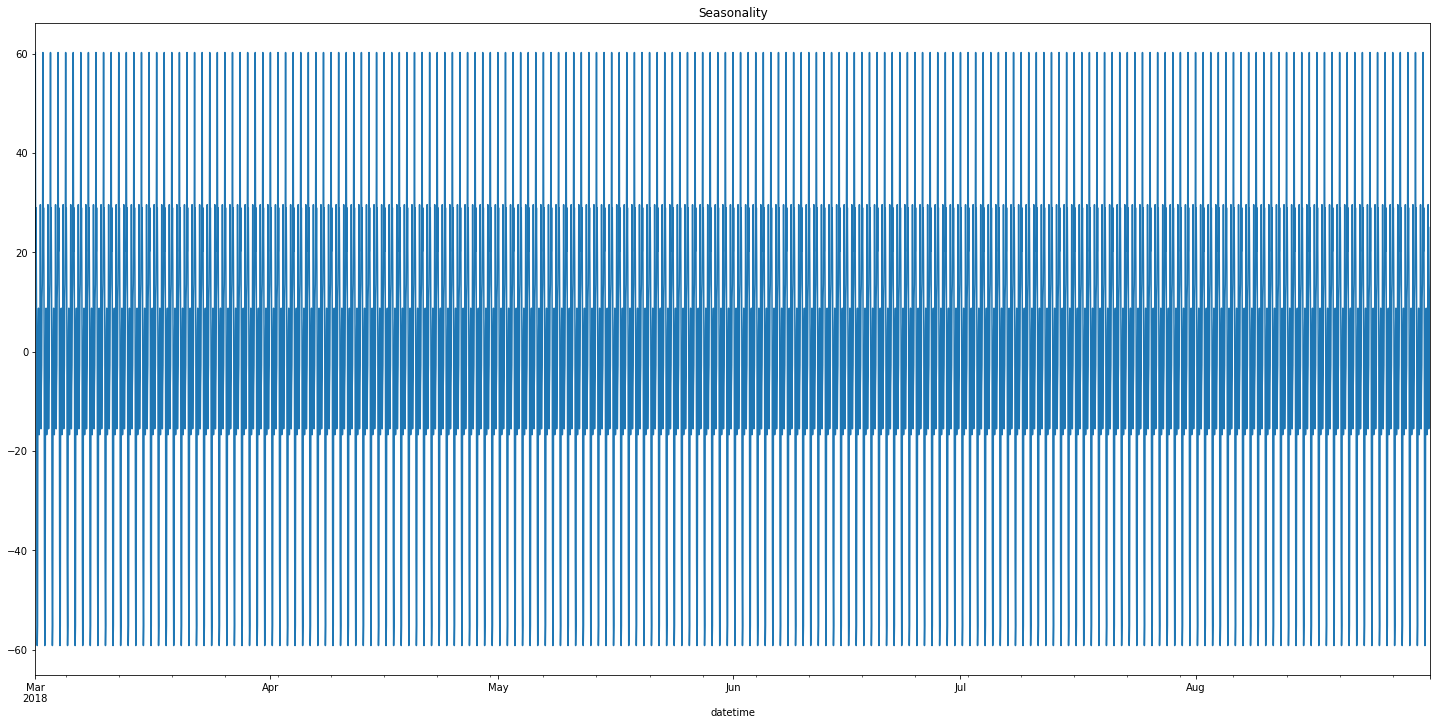

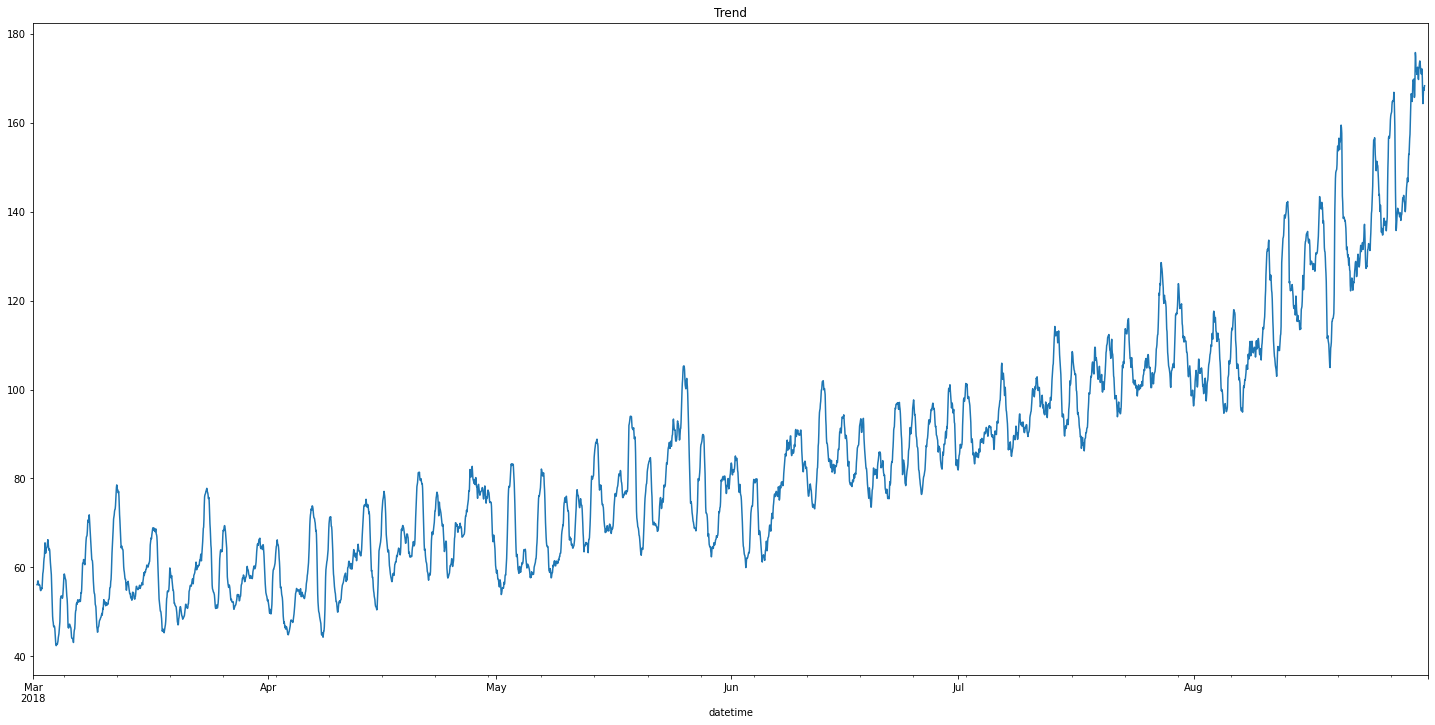

In [84]:
data = data.resample('1H').sum()
print(data.index.is_monotonic)
data.info()
display(data)
print()
display(data.describe())

decomposed = seasonal_decompose(data)

plt.figure(figsize=(25, 12))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.figure(figsize=(25, 12))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')


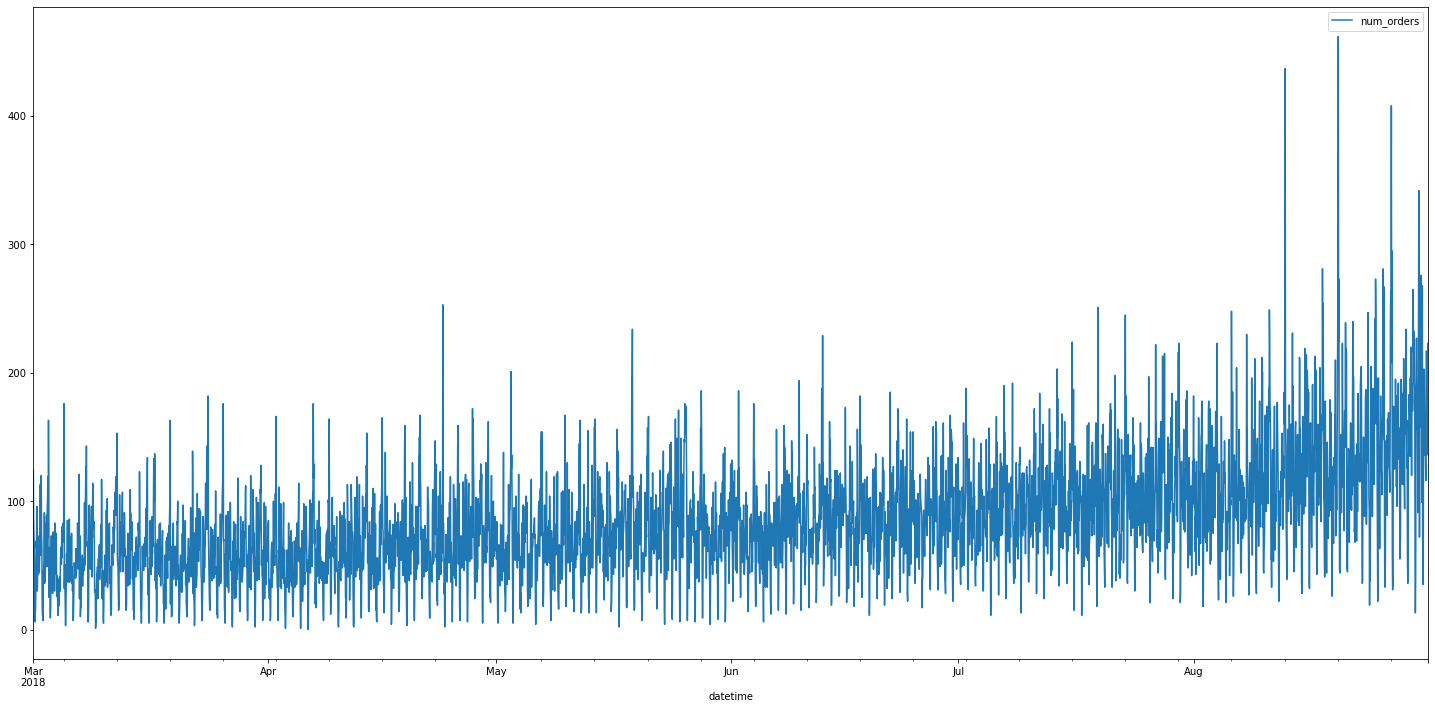

In [85]:
data.plot(figsize=(25, 12))
plt.show();


- **данные расположены в правильном хронологическом порядке**
- **пропусков нет**
- **визуально, значения в пределах нормы**
- **слишком много колебаний, требуется скользящая средняя**
- **среднее и стандартное отклонение меняются - нестационарный временной ряд**
- **стабильная сезонность. сезон меняется каждый час. В зависимости от времени может быть 30-60 заказов в час**
- **рост популярности услуг**

## Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.

Напишем функцию для создания признаков. Создадим признаки для горизонта прогнозирования в один шаг функцией make_features. Предыдущие значения временного ряда подскажут, будет ли функция x(t) расти или уменьшаться. 

In [86]:
def make_features(df, max_lag, rolling_mean_size):
    new_data = df#.copy()
    new_data['year'] = new_data.index.year
    new_data['month'] = new_data.index.month
    new_data['day'] = new_data.index.day
    new_data['dayofweek'] = new_data.index.dayofweek
    new_data['hour'] = new_data.index.hour

    for lag in range(1, max_lag + 1):
        new_data['lag_{}'.format(lag)] = new_data['num_orders'].shift(lag)

    new_data['rolling_mean'] = (new_data['num_orders'].shift()
                                              .rolling(rolling_mean_size)
                                              .mean())
    return new_data

make_features(data, 16, 4)
display(data.head())

train, valid = train_test_split(data, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid, shuffle=False, test_size=0.5)

train = train.dropna()
print('\ntrain', train.index.min(), train.index.max())
print('valid', valid.index.min(), valid.index.max())
print('test', test.index.min(), test.index.max())

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,...,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,1,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,2,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,4,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.5



train 2018-03-01 16:00:00 2018-07-26 03:00:00
valid 2018-07-26 04:00:00 2018-08-13 13:00:00
test 2018-08-13 14:00:00 2018-08-31 23:00:00


In [88]:
%%time
best_model = None
best_result = 10000
best_depth = 0
for depth in range(1, 6):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    result = mean_squared_error(target_valid, predictions) ** 0.5
    if result < best_result:
        best_model = model
        best_result = result
        best_depth = depth

print("RMSE DecisionTreeRegressor:", best_result,
      "\nГлубина дерева:", best_depth)


RMSE DecisionTreeRegressor: 38.35228205967026 
Глубина дерева: 5
Wall time: 47.9 ms


In [89]:
%%time
best_model = None
best_result = 10000
best_est = 0
best_depth = 0
for est in range(10, 51, 10):
    for depth in range(1, 11):
        model = RandomForestRegressor(random_state=12345, n_estimators=est,
                                      max_depth=depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        result = mean_squared_error(target_valid, predictions) ** .5
        if result < best_result:
            best_model = model
            best_result = result
            best_est = est
            best_depth = depth

print("RMSE RandomForestRegressor:", best_result,
      "Количество деревьев:", best_est,
      "Максимальная глубина:", best_depth)


RMSE RandomForestRegressor: 32.36003720801002 Количество деревьев: 40 Максимальная глубина: 10
Wall time: 14.4 s


### Модели градиентного бустинга

In [90]:
# объеденим треин и валидацию
train, test = train_test_split(data, shuffle=False, test_size=0.1)

train = train.dropna()
print('\ntrain', train.index.min(), train.index.max())
print('test', test.index.min(), test.index.max())

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']



train 2018-03-01 16:00:00 2018-08-13 13:00:00
test 2018-08-13 14:00:00 2018-08-31 23:00:00


In [91]:
def result(estimator, rf_grid):
    
    tscv = TimeSeriesSplit()
    
    model = GridSearchCV(estimator, rf_grid,
                         scoring='neg_root_mean_squared_error',
                         n_jobs=5, cv=tscv)
    
    result = model.fit(features_train, target_train)

    print(f'{str(estimator)}. Best Hyperparameters: %s' % result.best_params_)
    y_pred = model.predict(features_test)
    predictions = [round(value) for value in y_pred]
    
    print(f'{str(estimator)}. RMSE: %.2f' %
          mean_squared_error(target_test, predictions)**.5)


In [92]:
%%time
param = {'max_depth': [10, 25, 50, 75, 100, 200],
         'min_child_samples': [1, 2, 3]
         }
result(CatBoostRegressor(random_state=12345, iterations=200), param)


Learning rate set to 0.188297
0:	learn: 35.0380716	total: 22.8ms	remaining: 4.54s
1:	learn: 32.6065179	total: 45.6ms	remaining: 4.51s
2:	learn: 30.3203391	total: 72.6ms	remaining: 4.77s
3:	learn: 28.6193227	total: 95.6ms	remaining: 4.68s
4:	learn: 27.1354364	total: 119ms	remaining: 4.63s
5:	learn: 25.9330878	total: 141ms	remaining: 4.55s
6:	learn: 24.9950897	total: 165ms	remaining: 4.55s
7:	learn: 24.1185966	total: 188ms	remaining: 4.51s
8:	learn: 23.3489722	total: 211ms	remaining: 4.48s
9:	learn: 22.7370024	total: 234ms	remaining: 4.45s
10:	learn: 22.3528121	total: 258ms	remaining: 4.43s
11:	learn: 21.9130510	total: 283ms	remaining: 4.43s
12:	learn: 21.4093199	total: 307ms	remaining: 4.41s
13:	learn: 21.0864982	total: 331ms	remaining: 4.4s
14:	learn: 20.7298082	total: 355ms	remaining: 4.37s
15:	learn: 20.5043212	total: 378ms	remaining: 4.34s
16:	learn: 20.4616077	total: 399ms	remaining: 4.3s
17:	learn: 20.1255854	total: 422ms	remaining: 4.27s
18:	learn: 19.9623377	total: 444ms	remaini

In [93]:
%%time
param = {'n_estimators': [200, 300, 500, 700, 1000],
           "min_child_weight": [1, 3, 5, 10, 25],
           'max_depth': [3, 4, 7, 10, 25, 50]
           }
result(LGBMRegressor(random_state=12345, force_row_wise=True), param)


LGBMRegressor(force_row_wise=True, random_state=12345). Best Hyperparameters: {'max_depth': 4, 'min_child_weight': 25, 'n_estimators': 200}
LGBMRegressor(force_row_wise=True, random_state=12345). RMSE: 42.82
Wall time: 49.3 s


## Проверим Random Forest на тестовой выборке

Наилучшая модель - Random Forest.
RMSE на обучающей выборке: 15.20
RMSE на тестовой выборке: 44.88


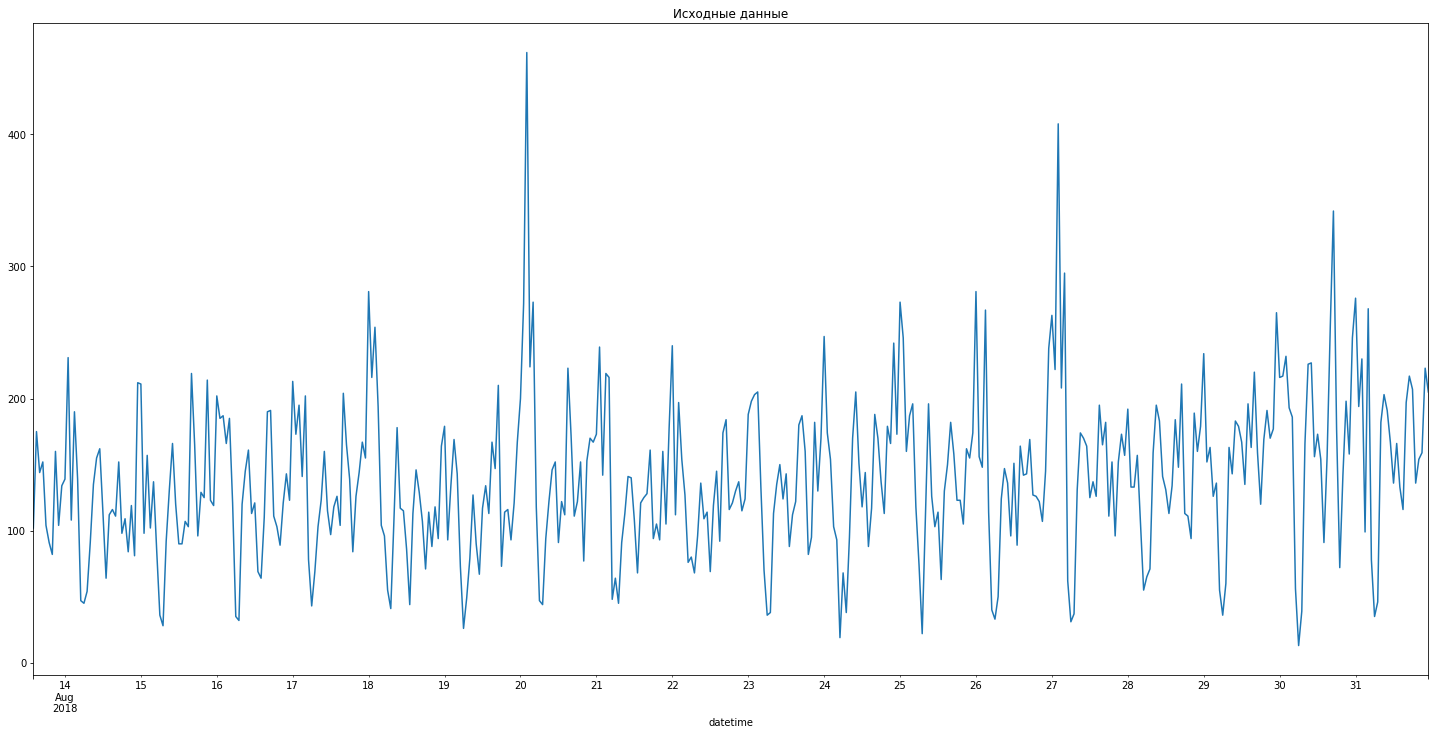

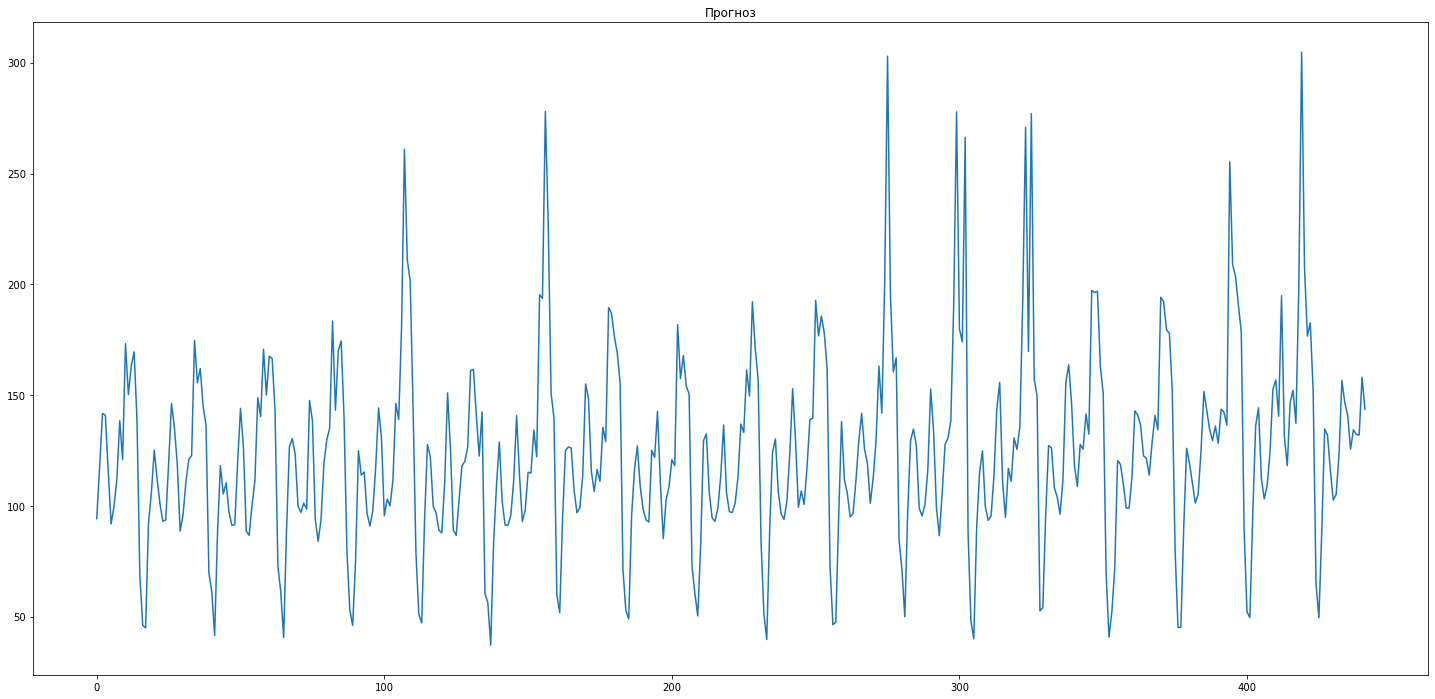

Wall time: 1.03 s


In [101]:
%%time
model = RandomForestRegressor(random_state=12345, n_estimators=40,max_depth=10)
model.fit(features_train, target_train)

predictions_train = model.predict(features_train)
predictions_test = model.predict(features_test)

clf = DummyClassifier(strategy='most_frequent', random_state=12345)
clf.fit(features_train, target_train)
print("Наилучшая модель - Random Forest.")
print("RMSE на обучающей выборке: %.2f" %
      mean_squared_error(target_train, predictions_train)**.5)
print("RMSE на тестовой выборке: %.2f" %
      mean_squared_error(target_test, predictions_test)**.5)

test['num_orders'].plot(figsize=(25, 12))
plt.title('Исходные данные')
plt.show();

pd.Series(model.predict(features_test)).plot(figsize=(25, 12))
plt.title('Прогноз')
plt.show();


## Общий вывод
**Построили модели для предсказания количества заказов на следующий час. Определили лучшую модель: `Random Forest`. Значение метрики RMSE на тестовой выборке не больше 48.**